In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
line = pd.read_csv('./data/line20220720free.csv')
line = line[['line_cd', 'line_name']]
station = pd.read_csv('./data/station20220720free.csv')
station = station[['station_cd', 'station_name', 'line_cd', 'address', 'lon', 'lat']]
join = pd.read_csv('./data/join20220720.csv')
for df in [line, station, join]:
    print(df.head())

   line_cd line_name
0     1001     中央新幹線
1     1002    東海道新幹線
2     1003     山陽新幹線
3     1004     東北新幹線
4     1005     上越新幹線
   station_cd station_name  line_cd           address         lon        lat
0     1110101           函館    11101    北海道函館市若松町１２-１３  140.726413  41.773709
1     1110102          五稜郭    11101           函館市亀田本町  140.733539  41.803557
2     1110103           桔梗    11101  北海道函館市桔梗３丁目４１-３６  140.722952  41.846457
3     1110104          大中山    11101       亀田郡七飯町大字大中山  140.713580  41.864641
4     1110105           七飯    11101         亀田郡七飯町字本町  140.688556  41.886971
   line_cd  station_cd1  station_cd2
0     1002       100201       100202
1     1002       100202       100203
2     1002       100203       100204
3     1002       100204       100205
4     1002       100205       100206


In [3]:
# station names to show on a figure
VERTICES = ['西新井', 'つくば', '南栗橋', '春日部']
# lines to add manually
EDGES = ['つくばエクスプレス', '東武伊勢崎線', '東武日光線', '東武野田線', 'JR埼京線']

In [5]:
# 路線を自動取得
lines_to_go = set()
for g in VERTICES:
    line_cds = station[station['station_name'] == g]['line_cd'].values
    for cd in line_cds:
        lines_to_go.add(cd)
print(lines_to_go)

lines_manual_cd = list(map(lambda l: line[line['line_name']==l]['line_cd'].values[0], EDGES))
for cd in lines_manual_cd:
    lines_to_go.add(cd)
print(lines_to_go)

{21002, 21003, 21004, 99309, 21006}
{21002, 21003, 21004, 99309, 21006, 11321}


In [6]:
constraint = ''
assert len(lines_manual_cd) > 0
for i, cd in enumerate(lines_to_go):
    if i > 0: constraint += ' or '
    constraint += f'line_cd == {cd}'
print(constraint)

station_sub = station.query(constraint)
join_sub = join.query(constraint)

line_cd == 21002 or line_cd == 21003 or line_cd == 21004 or line_cd == 99309 or line_cd == 21006 or line_cd == 11321


In [7]:
#グラフの宣言
G = nx.Graph()
#頂点を駅名にする
G.add_nodes_from(station_sub["station_name"])
#plotの座標を設定
pos = {}
for i, j, k in zip(station_sub["station_name"], station_sub["lon"], station_sub["lat"]):
  pos[i] = (j, k)
#リストeにstation_nameとstation_cdを格納し、リンクさせる
e = []
for i, j in zip(station_sub["station_name"], station_sub["station_cd"]):
  e.append([i, j])
#グラフに辺情報を加える
for i, j in zip(join_sub["station_cd1"], join_sub["station_cd2"]):
    for k in e:
      if k[1] == i:
        for l in e:
          if l[1] == j:
            G.add_edge(k[0], l[0])

# g2 = nx.DiGraph(G)

In [6]:
path = nx.shortest_path(G, source='つくば', target='栗橋')
print(len(path), path, path[len(path)//2])
path = nx.shortest_path(G, source='幸手', target='栗橋')
print(len(path), path, path[len(path)//2])

28 ['つくば', '研究学園', '万博記念公園', 'みどりの', 'みらい平', '守谷', '柏たなか', '柏の葉キャンパス', '流山おおたかの森', '初石', '江戸川台', '運河', '梅郷', '野田市', '愛宕', '清水公園', '七光台', '川間', '南桜井', '藤の牛島', '春日部', '北春日部', '姫宮', '東武動物公園', '杉戸高野台', '幸手', '南栗橋', '栗橋'] 愛宕
3 ['幸手', '南栗橋', '栗橋'] 南栗橋


In [7]:
path = nx.shortest_path(G, source='南栗橋', target='つくば')
print(len(path), path, path[len(path)//2])

27 ['南栗橋', '幸手', '杉戸高野台', '東武動物公園', '姫宮', '北春日部', '春日部', '藤の牛島', '南桜井', '川間', '七光台', '清水公園', '愛宕', '野田市', '梅郷', '運河', '江戸川台', '初石', '流山おおたかの森', '柏の葉キャンパス', '柏たなか', '守谷', 'みらい平', 'みどりの', '万博記念公園', '研究学園', 'つくば'] 野田市


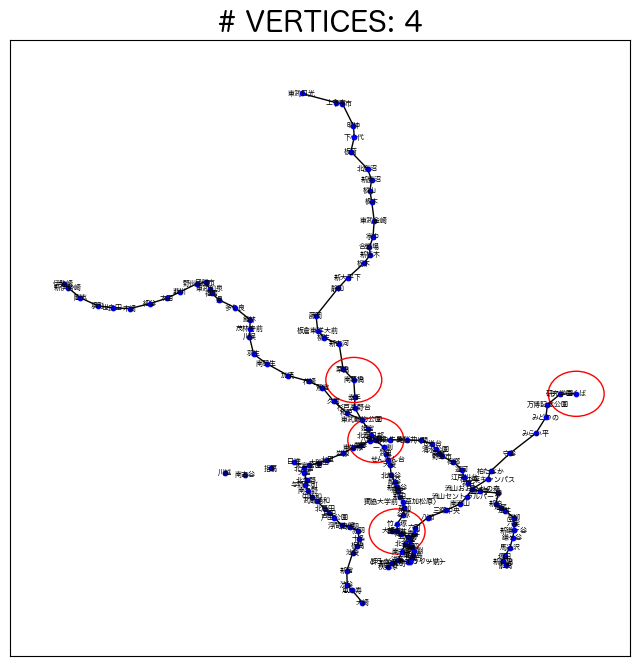

In [10]:
figsize = (8, 8)
font_family = 'Hiragino Maru Gothic Pro'
station_font_size = 5

_, axs = plt.subplots(1, 1, figsize=figsize)
axs.set_title(f'# VERTICES: {len(VERTICES)}', fontsize=20, fontname=font_family)
nx.draw_networkx(G, pos, node_color='b', node_size=10,
                font_size=station_font_size, font_family=font_family)
for c in list(map(lambda p: pos[p], VERTICES)):
    circle = plt.Circle(c, .05, fill=False, color='red')
    axs.add_artist(circle)
plt.show()